In [74]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [26]:
labels=pickle.load( open('labels.pkl', 'rb'))
features=pickle.load( open('features.pkl', 'rb'))
features_tfidf= pickle.load( open('features_tfidf.pkl', 'rb'))
word_tfidf_weights=pickle.load( open('word_tfidf_weights.pkl', 'rb'))

# TFIDF vectors with non numeric features

In [27]:
scaler=StandardScaler()
norm_features=scaler.fit_transform(features_tfidf)
train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
print("----------------Train data------------------------\n")
print(" train data features shape {} \n train data labels shape {}\n".format(train_ft.shape,train_labels.shape))
print("-----------------Test data-------------------------\n")
print(" test data features shape {} \n test data labels shape {}".format(test_ft.shape,test_labels.shape))

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


In [28]:
clf = LogisticRegression(random_state=0).fit(train_ft, train_labels)

In [33]:
def get_metrics(clf,test_ft,test_labels):
    pred_labels=clf.predict(test_ft)
    print(classification_report(pred_labels,test_labels))

In [34]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      6929
           1       0.92      0.91      0.92      7379

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



In [35]:
def plot_ROC(test):
    
    pred_labels=clf.predict(test_ft)
    fpr, tpr, thresholds = roc_curve(test,pred_labels)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
    

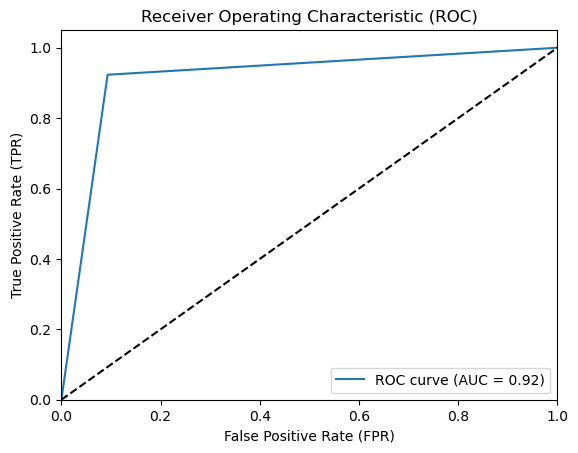

In [37]:
plot_ROC(test_labels)

In [75]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)

In [76]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7078
           1       0.90      0.91      0.90      7230

    accuracy                           0.90     14308
   macro avg       0.90      0.90      0.90     14308
weighted avg       0.90      0.90      0.90     14308



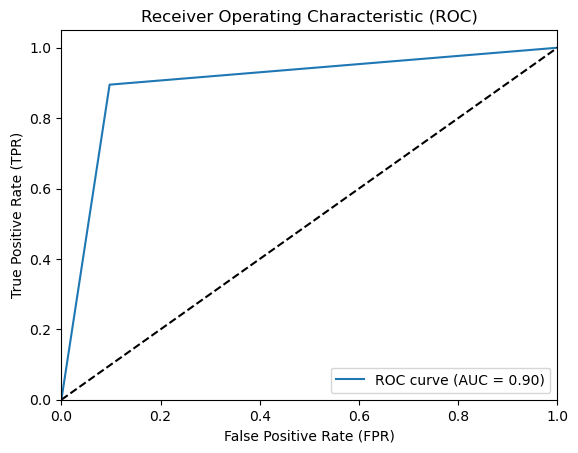

In [77]:
plot_ROC(test_labels)

# word2vec features with non numeric features

In [45]:
doc=list(features["combined_text"])
non_text_features = features.drop(columns=['title', 'text', 'combined_text', 'label'])
non_text_features_np=non_text_features.to_numpy()

In [40]:
def tokenize_words(text):
    tokenized_words,vocab=[],[]
    for i in text:
        tokenizer = RegexpTokenizer(r'\w+')     #using regular expression tokenizer
        wrd_token=tokenizer.tokenize(i)         
        tokenized_words.append(wrd_token)
        vocab.extend(wrd_token)
    return tokenized_words, vocab


doc_tokens_w2v,vocab=tokenize_words(doc)  #tokenizing the doc(ans+que)

In [41]:
model_doc=Word2Vec(doc_tokens_w2v,min_count=2,window=4) 

In [42]:
sentence_vectors = []
for sentence in doc:
    tokens = word_tokenize(sentence.lower())
    sentence_vector = np.zeros(model_doc.vector_size)
    if len(tokens)==0:
        sentence_vectors.append([0]*100)
    else:
        for token in tokens:
            if token in model_doc.wv:
                token_vector = model_doc.wv[token]
                sentence_vector += token_vector
        sentence_vector /= len(tokens)
        sentence_vectors.append(sentence_vector)

# Convert the list of sentence vectors to a NumPy array
sentence_vectors = np.array(sentence_vectors)

In [43]:
sentence_vectors.shape

(71537, 100)

In [44]:
non_text_features = features.drop(columns=['title', 'text', 'combined_text', 'label'])
non_text_features_np=non_text_features.to_numpy()

In [48]:
features_w2v = np.hstack((sentence_vectors, non_text_features_np))

In [49]:
pickle.dump(features_w2v, open('features_w2v.pkl', 'wb'))

In [50]:
features_w2v = pickle.load( open('features_tfidf.pkl', 'rb'))

In [78]:
scaler=StandardScaler()
norm_features=scaler.fit_transform(features_w2v)
train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
print("----------------Train data------------------------\n")
print(" train data features shape {} \n train data labels shape {}\n".format(train_ft.shape,train_labels.shape))
print("-----------------Test data-------------------------\n")
print(" test data features shape {} \n test data labels shape {}".format(test_ft.shape,test_labels.shape))

----------------Train data------------------------

 train data features shape (57229, 115) 
 train data labels shape (57229,)

-----------------Test data-------------------------

 test data features shape (14308, 115) 
 test data labels shape (14308,)


In [53]:
clf = LogisticRegression(random_state=0).fit(train_ft, train_labels)

In [54]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      6787
           1       0.93      0.92      0.92      7521

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



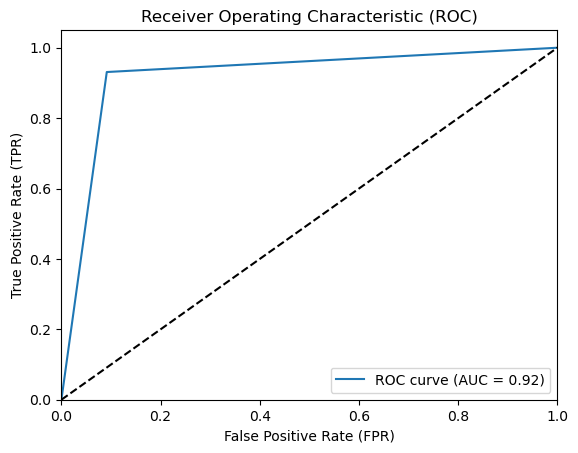

In [55]:
plot_ROC(test_labels)

In [79]:
clf = LinearDiscriminantAnalysis().fit(train_ft, train_labels)

In [80]:
get_metrics(clf,test_ft,test_labels)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7139
           1       0.89      0.91      0.90      7169

    accuracy                           0.90     14308
   macro avg       0.90      0.90      0.90     14308
weighted avg       0.90      0.90      0.90     14308



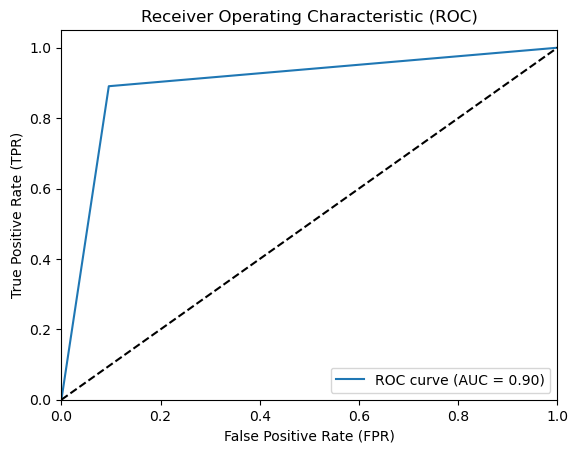

In [81]:
plot_ROC(test_labels)

#  word2vec vector with neural networks

In [56]:
train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [57]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have already preprocessed and split your dataset into X_train, y_train, X_val, y_val

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(115,)))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7424      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 4s 2ms/step - loss: 0.2151 - accuracy: 0.9114 - val_loss: 0.1625 - val_accuracy: 0.9346
Epoch 2/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1609 - accuracy: 0.9352 - val_loss: 0.1376 - val_accuracy: 0.9450
Epoch 3/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1417 - accuracy: 0.9438 - val_loss: 0.1213 - val_accuracy: 0.9520
Epoch 4/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1285 - accuracy: 0.9492 - val_loss: 0.1095 - val_accuracy: 0.9570
Epoch 5/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1169 - accuracy: 0.9536 - val_loss: 0.0977 - val_accuracy: 0.9649
Epoch 6/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1064 - accuracy: 0.9583 - val_loss: 0.0851 - val_accuracy: 0.9668
Epoch 7/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.0972 - accuracy: 0.9624 - val_loss: 0.0783 - val_accuracy:

In [59]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 1ms/step - loss: 0.1803 - accuracy: 0.9395
Test Loss: 0.18027165532112122, Test Accuracy: 0.9394744038581848


In [60]:
def plot_loss_acc(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

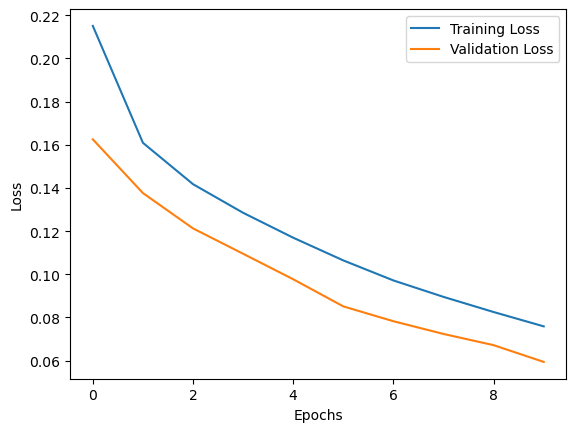

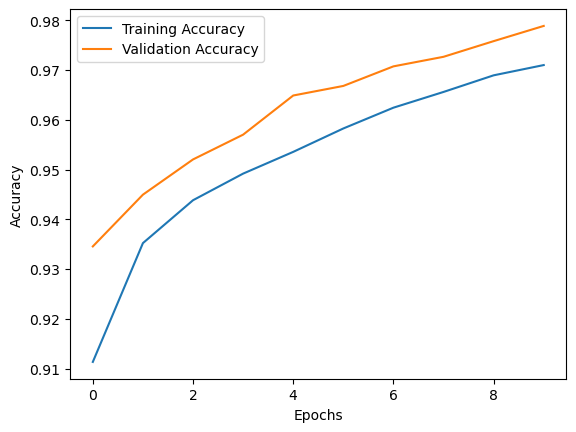

In [61]:
plot_loss_acc(history)

# tfidf weighted word2vec 

In [156]:
sentence_vectors_tf = []

# Process each sentence and compute its vector
for i,sentence in enumerate(doc):
    tokens = word_tokenize(sentence.lower())
    sentence_vector = np.zeros(model_doc.vector_size)
    if len(tokens)==0:
         sentence_vectors_tf.append([0]*100)
    else:
        for token in tokens:
            if token in model_doc.wv:
                token_vector = model_doc.wv[token]
                sentence_vector += token_vector

        sentence_vector /= len(tokens)
        sentence_vector *= word_tfidf_weights[i]
        sentence_vectors_tf.append(sentence_vector)

# Convert the list of sentence vectors to a NumPy array
sentence_vectors_tf = np.array(sentence_vectors)
sentence_vectors_tf = np.nan_to_num(sentence_vectors_tf, nan=0.0)

In [166]:
pickle.dump(sentence_vectors_tf, open('w2v_tf_vectors.pkl', 'wb'))

In [62]:
sentence_vectors_tf=pickle.load( open('w2v_tf_vectors.pkl', 'rb'))

In [63]:
sentence_vectors_tf.shape

(71537, 100)

In [64]:
train_ft,test_ft,train_labels,test_labels=train_test_split(sentence_vectors_tf,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

# Print the shape of each set
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 100)
Validation set shape: (11446, 100)
Test set shape: (14308, 100)


In [65]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(100,)))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                3232      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


In [66]:
opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 4s 2ms/step - loss: 0.3477 - accuracy: 0.8504 - val_loss: 0.2978 - val_accuracy: 0.8757
Epoch 2/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2944 - accuracy: 0.8773 - val_loss: 0.2764 - val_accuracy: 0.8840
Epoch 3/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2785 - accuracy: 0.8848 - val_loss: 0.2591 - val_accuracy: 0.8927
Epoch 4/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2675 - accuracy: 0.8885 - val_loss: 0.2546 - val_accuracy: 0.8929
Epoch 5/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2588 - accuracy: 0.8927 - val_loss: 0.2553 - val_accuracy: 0.8945
Epoch 6/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2518 - accuracy: 0.8960 - val_loss: 0.2673 - val_accuracy: 0.8861
Epoch 7/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.2463 - accuracy: 0.8973 - val_loss: 0.2310 - val_accuracy:

In [67]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 1ms/step - loss: 0.2482 - accuracy: 0.8947
Test Loss: 0.24815793335437775, Test Accuracy: 0.8947442173957825


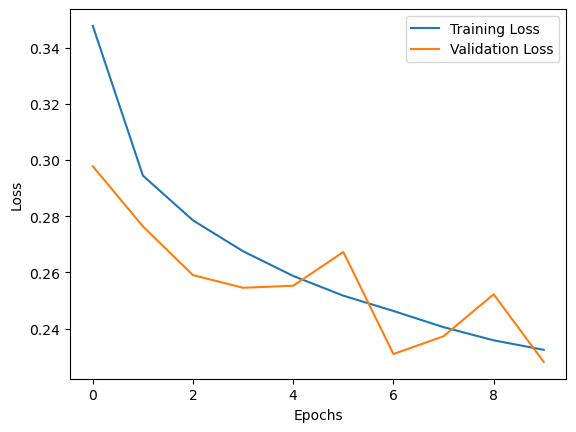

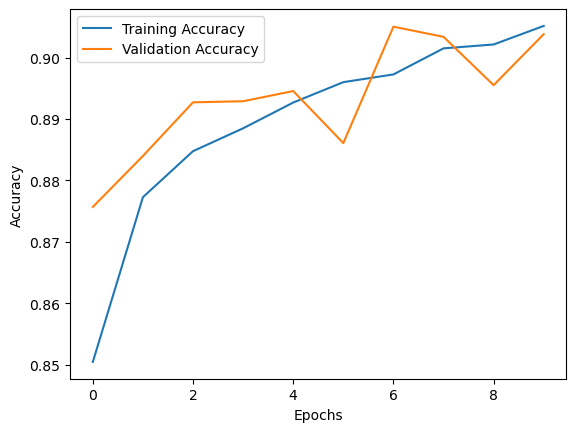

In [68]:
plot_loss_acc(history)

# TF-IDF weighted Word2vec with non numeric features

In [69]:
features_w2v = np.hstack((sentence_vectors_tf, non_text_features_np))
scaler=StandardScaler()
norm_features=scaler.fit_transform(features_w2v)

train_ft,test_ft,train_labels,test_labels=train_test_split(norm_features,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 115)
Validation set shape: (11446, 115)
Test set shape: (14308, 115)


In [70]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(115,)))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                3712      
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


In [71]:
opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_ft, train_labels, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1789/1789 [==============================] - 5s 2ms/step - loss: 0.2118 - accuracy: 0.9152 - val_loss: 0.1692 - val_accuracy: 0.9340
Epoch 2/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1656 - accuracy: 0.9344 - val_loss: 0.1563 - val_accuracy: 0.9383
Epoch 3/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1524 - accuracy: 0.9397 - val_loss: 0.1436 - val_accuracy: 0.9467
Epoch 4/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1452 - accuracy: 0.9432 - val_loss: 0.1372 - val_accuracy: 0.9468
Epoch 5/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1398 - accuracy: 0.9450 - val_loss: 0.1285 - val_accuracy: 0.9514
Epoch 6/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1344 - accuracy: 0.9474 - val_loss: 0.1264 - val_accuracy: 0.9519
Epoch 7/10
1789/1789 [==============================] - 3s 2ms/step - loss: 0.1301 - accuracy: 0.9494 - val_loss: 0.1190 - val_accuracy:

In [72]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ft, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

448/448 [==============================] - 1s 1ms/step - loss: 0.1572 - accuracy: 0.9417
Test Loss: 0.1571870893239975, Test Accuracy: 0.9417109489440918


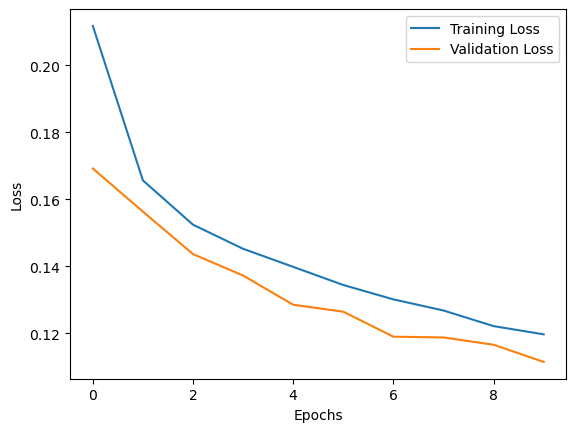

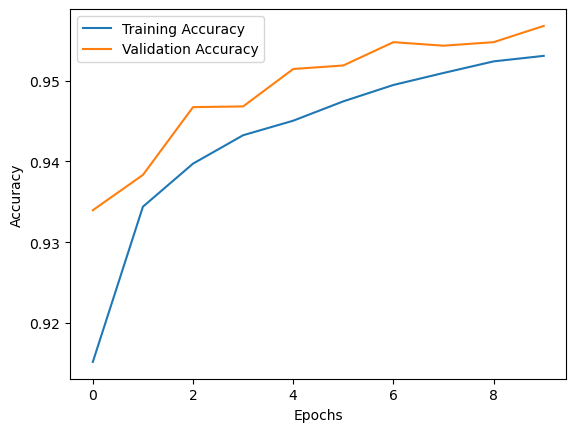

In [73]:
plot_loss_acc(history)